In [1]:
import pypsa
import pandas as pd
import numpy as np
import pypsatopo

In [2]:
solver = "cbc"

In [3]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [4]:
calculate_annualised_capex(795*0.85, 0.05, 20)

54.22392829410963

In [5]:
795*0.85/20

33.7875

*** 
Check-point 1:

**Build a network in PyPSA with three nodes (`bus`) and the following components to model a simple green hydrogen production system:**

1. An `Electricity` bus with electricity as `carrier`.
   1. A wind generator connected to this bus.
   2. A solar generator connected to this bus.
2. A `Hydrogen` bus with hydrogen as `carrier`.
   1. A hydrogen demand load connected to this bus.
3. An electrolyser link to convert electricity into hydrogen.
4. A `Hydrogen_storage` bus with hydrogen as `carrier`.
   1. A hydrogen store connected to this bus.
5. A bi-directional link to transfer the hydrogen between hydrogen and hydrogen storage buses.

**For simplicity, we assume the hydrogen demand profile to be flat for now. Afterwards, we want to supply electricy by attaching one renewable power plant implemented as (`generator`) (you have to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year). As help you should have a look at the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/) and the [minimal lopf example](https://pypsa.readthedocs.io/en/latest/examples/minimal_example_pf.html), understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa.readthedocs.io/en/stable/user-guide/optimal-power-flow.html).**

> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

<img src="../data/block diagrams/d2_e3-1.svg" width=600/>

Initialize network

In [6]:
# Create empty PyPSA network
network = pypsa.Network()

In [7]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023","01-01-2024",freq="H",inclusive='left')
network.set_snapshots(snapshots)

In [8]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

In [9]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("../data/weather data/example_onshore_wind_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern)*365, index=network.snapshots)

In [10]:
# Import an example of solar daily pattern
solar_pattern = pd.read_csv("../data/weather data/example_solar_daily_pattern.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern)*365, index=network.snapshots)

Add an `electricity` bus with electricity as `carrier`

In [11]:
network.add(class_name="Bus", name="electricity", carrier="electricity", type="electricity")

Add a `hydrogen` bus with hydrogen as `carrier`

In [12]:
network.add(class_name="Bus", name="hydrogen", carrier="hydrogen", type="hydrogen")

Add a `hydrogen_storage` bus with hydrogen as `carrier`

In [13]:
network.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen", type="hydrogen_storage")

In [14]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,electricity,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,hydrogen,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,hydrogen_storage,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,


Add a constant hourly hydrogen load of `100MW` at the hydrogen bus. The name of the load can be `hydrogen_load`

In [15]:
network.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load" )

In [16]:
network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
hydrogen_load,hydrogen,hydrogen,hydrogen_load,100.0,0.0,-1.0


Add a store at the hydrogen_storage bus with a initial energy capacity of `0MWh`, and marginal cost of `0$/MWh` into the network. The name of the store can be `hydrogen_tank`. 

In [17]:
eur_to_usd = 1.1
lifetime = 25
interest = 0.05

CAPEX = 4779.9527 #	$/MWh
FOM = 0.43 #%/year
lifetime = 20 # years

In [18]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=1, #$/MWh
)

Add a bidirectional link, representing the hydrogen charging and discharging between hydrogen and hydrogen_storage with marginal cost of `0$/MWh` into the network? The name of the link can be `hydrogen_flow`. 

In [19]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,electricity,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,hydrogen,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,hydrogen_storage,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,


In [20]:
network.add(
      class_name="Link",
      name="hydrogen_flow",
      bus0="hydrogen",
      bus1="hydrogen_storage",
      p_nom_extendable=True,
      marginal_cost=1, #$/MWh
      efficiency=1,
      p_min_pu=-1) #bidirectional flow

Add a wind generator at the electricity bus with a initial capacity of `100MW`, maximum capacity of `500MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime? The name of the generator can be `onshore_wind`. 

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [21]:
# Onshore Wind's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 25
interest = 0.05

CAPEX = 1420 * 1000 * eur_to_usd # $/MW
FOM = 28 * eur_to_usd  # $/MW fixed
VOM = 0 # $/MWh variable

efficiency = 1

In [22]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile
)

Add a solar generator at the electricity bus with a initial capacity of `10MW`, maximum capacity of `500MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime? The name of the generator can be `solar`. 

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [23]:
# Solar's techno-economic parameters are given as:
eur_to_use = 1.1
lifetime = 20
interest = 0.05

CAPEX = 970  * 1000 * eur_to_use # $/MW
FOM = 16 * eur_to_use  # $/MW fixed
VOM = 0 # $/MWh variable

efficiency = 1

In [24]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom_min=10, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile
)

Add an electrolyser link, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [25]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.05

CAPEX = 1590 * eur_to_usd # $/MW
FOM = 32 * eur_to_usd  # $/MW fixed
VOM = 0 # $/MWh variable
efficiency = 0.59

In [26]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime
)

Now try to solve your network

In [27]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 40.66it/s]
INFO:linopy.io: Writing time: 1.21s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-zezdxyd6.lp -pyomo False -solve -solu /tmp/linopy-solve-banqboi8.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 39055 (-83590) rows, 21539 (-31026) columns and 94900 (-128120) elements
Perturbing problem by 0.001% of 316945.4 - largest nonzero change 0.10657382 ( 0.089193464%) - largest zero change 0.10657099
0  Obj 11945735 Primal inf 1461123.6 (8760)
420  Obj 12321838 Primal inf 1537364 (8769)
840  Obj 13367990 Primal inf 1688360.6 (8918)
1260  Obj 15436

('ok', 'optimal')

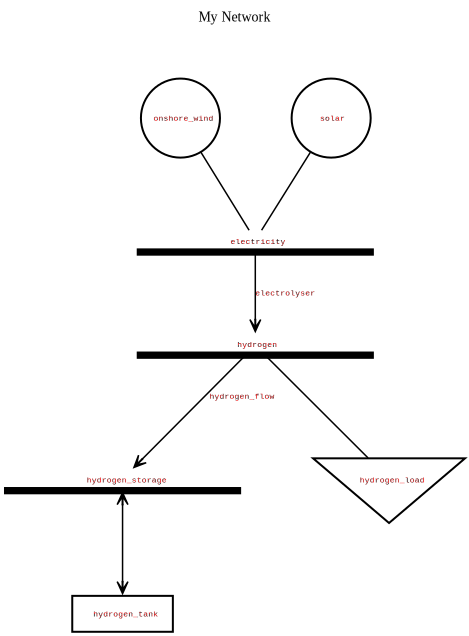

0

In [28]:

pypsatopo.generate(network)

In [29]:
network.stores_t.p

Store,hydrogen_tank
snapshot,
2023-01-01 00:00:00,96.673874
2023-01-01 01:00:00,96.025378
2023-01-01 02:00:00,94.125704
2023-01-01 03:00:00,93.261770
2023-01-01 04:00:00,94.350843
...,...
2023-12-31 19:00:00,85.989585
2023-12-31 20:00:00,83.098054
2023-12-31 21:00:00,83.603395


In [30]:
pd.concat([network.stores_t.e,network.stores_t.p],axis=1).head()


Store,hydrogen_tank,hydrogen_tank
snapshot,,
2023-01-01 00:00:00,652.05110,96.673874
2023-01-01 01:00:00,556.02572,96.025378
2023-01-01 02:00:00,461.90002,94.125704
2023-01-01 03:00:00,368.63825,93.261770
2023-01-01 04:00:00,274.28740,94.350843


Lets look at some results! Back to read the docs. How would you look at results?

In [31]:
network.generators.p_nom_opt

Generator
onshore_wind    100.00000
solar           636.86863
Name: p_nom_opt, dtype: float64

In [32]:
network.links_t.p0

Link,hydrogen_flow,electrolyser
snapshot,,
2023-01-01 00:00:00,-96.673874,5.637503
2023-01-01 01:00:00,-96.025378,6.736647
2023-01-01 02:00:00,-94.125704,9.956434
2023-01-01 03:00:00,-93.261770,11.420729
2023-01-01 04:00:00,-94.350843,9.574842
...,...,...
2023-12-31 19:00:00,-85.989585,23.746466
2023-12-31 20:00:00,-83.098054,28.647366
2023-12-31 21:00:00,-83.603395,27.790856


<Axes: xlabel='snapshot'>

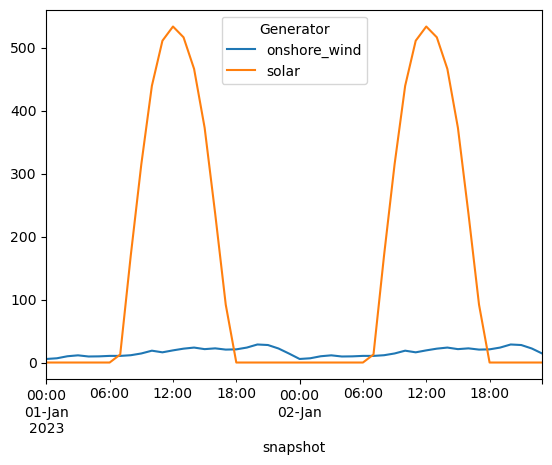

In [33]:
network.generators_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

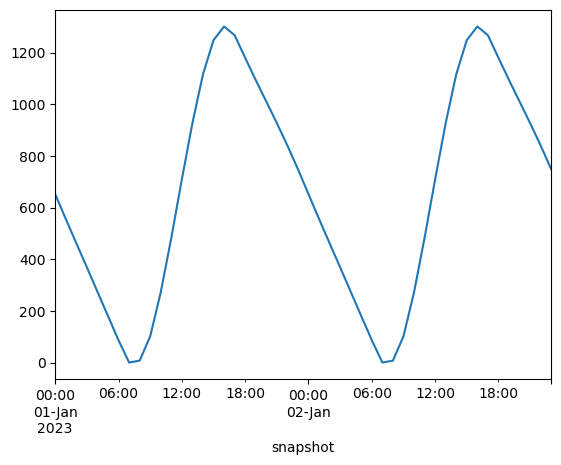

In [34]:
network.stores_t.e["hydrogen_tank"][:24*2].plot()

In [35]:
# Exporting check-point 1 network
network.export_to_netcdf("../results/network_d2_e3-1.nc")

INFO:pypsa.io:Exported network network_d2_e3-1.nc has generators, loads, stores, links, buses


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   generators_i: 2, generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 2, loads_i: 1,
                                   loads_t_p_i: 1, stores_i: 1,
                                   stores_t_p_i: 1, stores_t_e_i: 1,
                                   links_i: 2, links_t_p0_i: 2,
                                   links_t_p1_i: 2, buses_i: 3, buses_t_p_i: 2,
                                   buses_t_marginal_price_i: 3)
Coordinates: (12/16)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * generators_i                  (generators_i) object 16B 'onshore_wind' 's...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 16B 'onsho...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
    ...                            ...
  * links_i                       (links_i) object 16B 'hydrogen_flow' 'elect...
  * links_t_p0_i                  (links_t_p0_i) object 16B 'hydrogen_flow' '...
  * links_t_p1_i                  (links_t_p1_i) object 16B 'hydrogen_flow' '...
  * buses_i                       (buses_i) object 24B 'electricity' ... 'hyd...
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 24B 'elec...
Data variables: (12/47)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    links_t_p0                    (snapshots, links_t_p0_i) float64 140kB -96...
    links_t_p1                    (snapshots, links_t_p1_i) float64 140kB 96....
    buses_type                    (buses_i) object 24B 'electricity' ... 'hyd...
    buses_carrier                 (buses_i) object 24B 'electricity' ... 'hyd...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 0.0 ...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 210kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           66223336.21198048
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

***
Check-point 2:

**Instead of the fixed hydrogen load add an hourly one at the hydrogen bus according to the daily pattern of industrial hydrogen demand (`100MW per hour` from 1am to 7pm, followed by a 5-hour shutdown). The name of the load can be `hydroge_load`**

**Then remove the electrolyser link from the previous exercise and replace it with a new electrolyser link including the compressor needed to pressurize the produced hydrogen. Cost assumptions and the efficiency of this component must be adjusted**

The block diagram representing the system remains the same as before:
<img src="../data/block diagrams/d2_e3-1.svg" width=600/>

In [36]:
# Import check-point 1 network
network = pypsa.Network("../results/network_d2_e3-1.nc")

INFO:pypsa.io:Imported network network_d2_e3-1.nc has buses, generators, links, loads, stores


In [37]:
# remove hydrogen load from previous check-point
network.remove(class_name="Load", name="hydrogen_load")

In [38]:
# remove electrolyser link from previous check-point
network.remove(class_name="Link", name="electrolyser")

To set hourly hydrogen demand, you need to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year. For help, please see the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/) and the [optimzation with Linopy](https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy.html). Make sure you understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [System Optimization documentation](https://pypsa.readthedocs.io/en/stable/user-guide/optimal-power-flow.html).

In [39]:
# Import an example of wind daily pattern
load_pattern = pd.read_csv("../data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
load_profile = pd.Series(list(load_pattern)*365, index=network.snapshots)

<Axes: xlabel='snapshot'>

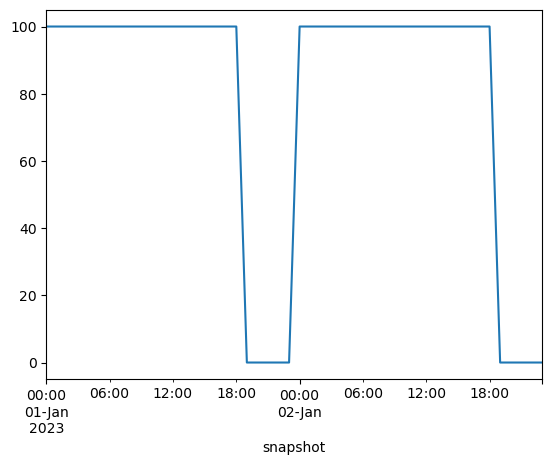

In [40]:
load_profile[:24*2].plot()

In [41]:
network.add(
    class_name="Load",
    name="hydrogen_load",
    bus="hydrogen", 
    p_set=load_profile
)

Add an electrolyser link including compressor, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, water_cost, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [42]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.05
water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 1590 * eur_to_usd # $/MW
FOM = 32 * eur_to_usd  # $/MW fixed
VOM = 0 # $/MWh variable
efficiency = 0.59

# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser) # unit: kWh_H2/kWh_el

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable

In [43]:
new_efficiency

0.5837994299964374

In [44]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + FOM + annualized_capex_com + FOM_COM, #$/MW
    marginal_cost=VOM + VOM_COM + water_cost, #$/MWh
    efficiency=new_efficiency,
    lifetime=lifetime
)

Ending of check-point 2 - Solve network, analyse results and export network

In [45]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 85.09it/s]
INFO:linopy.io: Writing time: 0.7s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-3qijfh6q.lp -pyomo False -solve -solu /tmp/linopy-solve-sem8swq8.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 37960 (-84685) rows, 20444 (-32121) columns and 93805 (-129215) elements
Perturbing problem by 0.001% of 19292.046 - largest nonzero change 0.00099989104 ( 0.51818062%) - largest zero change 0.00099983553
0  Obj 11949162 Primal inf 1181157 (6935)
414  Obj 12135597 Primal inf 1355059.3 (6968)
828  Obj 12173988 Primal inf 1434519.7 (7067)
1242  Obj 

('ok', 'optimal')

<Axes: xlabel='snapshot'>

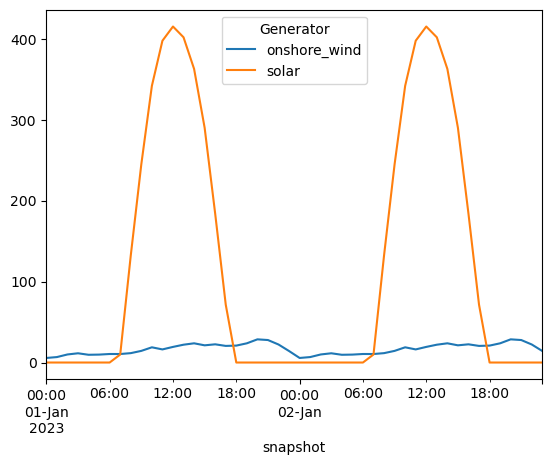

In [46]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

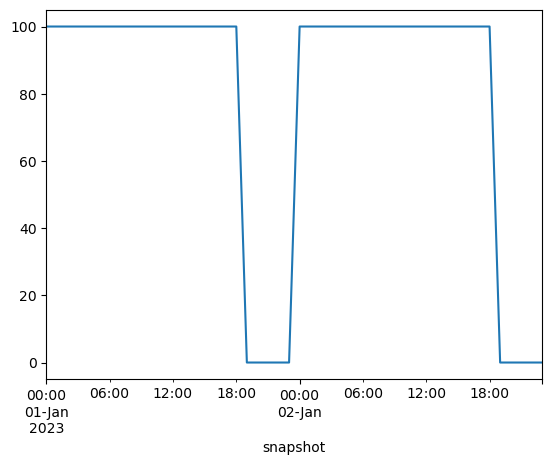

In [47]:
network.loads_t.p["hydrogen_load"][:24*2].plot()

<Axes: xlabel='snapshot'>

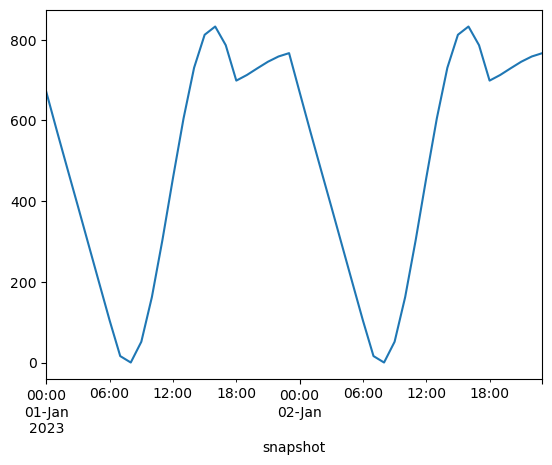

In [48]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
network.stores_t.e["hydrogen_tank"][:24*2].plot()

In [49]:
network.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator electricity         595.57735                 0.0  1.187908e+06   
Link      electricity         434.57276                 0.0  6.935000e+05   
          hydrogen            153.70333                 0.0  6.576970e+05   
Load      -                     0.00000                 0.0  0.000000e+00   
Store     hydrogen            832.86262                 0.0  3.288485e+05   

                         Withdrawal      Dispatch  Transmission  \
Generator electricity  0.000000e+00  1.187908e+06       0.00000   
Link      electricity  1.187908e+06 -4.944080e+05       0.00000   
          hydrogen     6.576970e+05  0.000000e+00       0.00073   
Load      -            6.935000e+05 -6.935000e+05       0.00000   
Store     hydrogen     3.288485e+05 -7.300004e-04       0.00000   

                       Capacity Factor  Curtailment  Capital Expenditure  \
Generator electricity         0.227688       0.0024         5.352533e+07   
Link      electricity         0.312044       0.0000         1.508777e+05   
          hydrogen            0.488471       0.0000         0.000000e+00   
Load      -                        NaN       0.0000         0.000000e+00   
Store     hydrogen            0.594092       0.0000         3.208229e+05   

                       Operational Expenditure       Revenue  Market Value  
Generator electricity             0.000000e+00  4.848311e+07  4.081386e+01  
Link      electricity             1.481945e+06  1.632823e+06  2.354468e+00  
          hydrogen                7.299999e-04  7.299960e-04  1.109934e-09  
Load      -                       0.000000e+00 -5.043675e+07           NaN  
Store     hydrogen               -7.300004e-04  3.208228e+05  9.755946e-01

<Axes: xlabel='snapshot'>

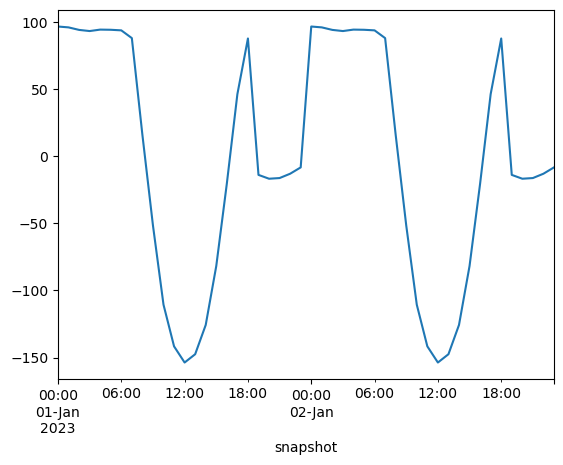

In [50]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
network.stores_t.p["hydrogen_tank"][:24*2].plot()

<Axes: xlabel='snapshot'>

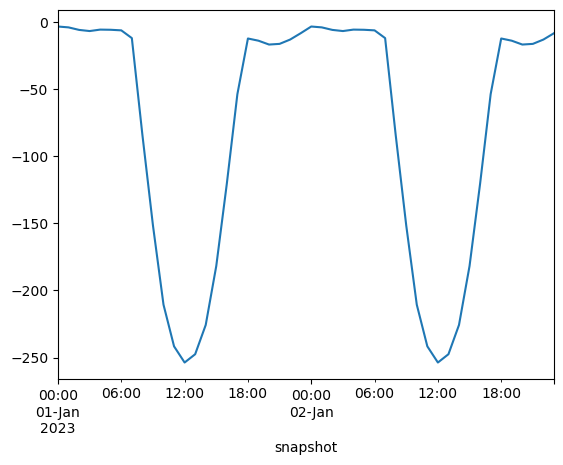

In [51]:
# Inspect the electrolysis input power
network.links_t.p1["electrolyser"][:24*2].plot()

<Axes: xlabel='snapshot'>

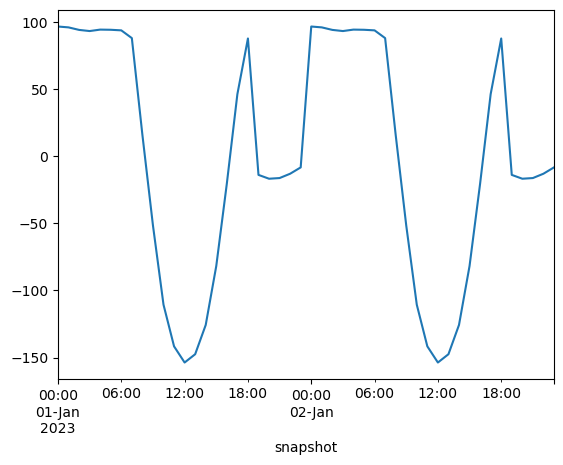

In [52]:
# Inspect the charging flow
network.links_t.p1['hydrogen_flow'][:24*2].plot()

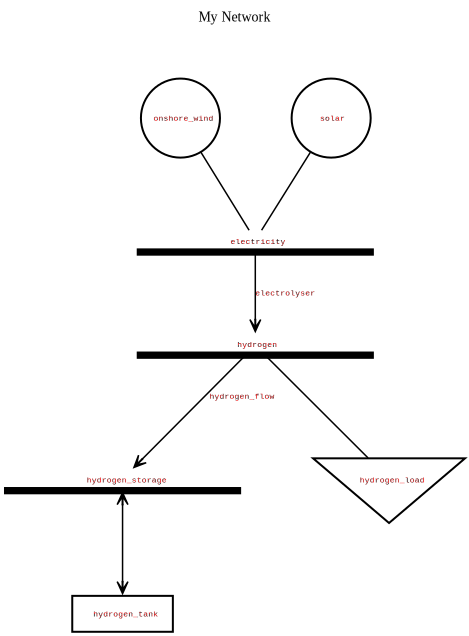

0

In [53]:
pypsatopo.generate(network)

In [54]:
# Exporting check-point 2 network
network.export_to_netcdf("../results/network_d2_e4-2.nc")

INFO:pypsa.io:Exported network network_d2_e4-2.nc has generators, loads, stores, links, buses


<xarray.Dataset> Size: 2MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   generators_i: 2, generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 2, loads_i: 1,
                                   loads_t_p_set_i: 1, loads_t_p_i: 1,
                                   stores_i: 1, stores_t_p_i: 1,
                                   stores_t_e_i: 1, links_i: 2,
                                   links_t_p0_i: 2, links_t_p1_i: 2,
                                   buses_i: 3, buses_t_p_i: 2,
                                   buses_t_marginal_price_i: 3)
Coordinates: (12/17)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * generators_i                  (generators_i) object 16B 'onshore_wind' 's...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 16B 'onsho...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
    ...                            ...
  * links_i                       (links_i) object 16B 'hydrogen_flow' 'elect...
  * links_t_p0_i                  (links_t_p0_i) object 16B 'hydrogen_flow' '...
  * links_t_p1_i                  (links_t_p1_i) object 16B 'hydrogen_flow' '...
  * buses_i                       (buses_i) object 24B 'electricity' ... 'hyd...
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 24B 'elec...
Data variables: (12/45)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) float64 0B 
    investment_periods_years      (investment_periods) float64 0B 
    ...                            ...
    links_t_p0                    (snapshots, links_t_p0_i) float64 140kB -96...
    links_t_p1                    (snapshots, links_t_p1_i) float64 140kB 96....
    buses_type                    (buses_i) object 24B 'electricity' ... 'hyd...
    buses_carrier                 (buses_i) object 24B 'electricity' ... 'hyd...
    buses_t_p                     (snapshots, buses_t_p_i) float64 140kB 0.0 ...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 210kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           55478979.38856795
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

***
Check-point 3:

**Add ammonia system**

In [55]:
# Import check-point 1 network
network = pypsa.Network("../results/network_d2_e4-2.nc")

INFO:pypsa.io:Imported network network_d2_e4-2.nc has buses, generators, links, loads, stores


In [56]:
# remove hydrogen load from previous check-point
network.remove(class_name="Load", name="hydrogen_load")

Add an `ammonia` and `ammonia_storage` buses with ammonia as `carrier`

In [57]:
network.add(class_name="Bus", name="ammonia", carrier="ammonia", type="ammonia")

In [58]:
network.add(class_name="Bus", name="ammonia_storage", carrier="ammonia", type="ammonia_storage")

Add an Haber-Bosch link based on provided CAPEX, FOM, VOM, water_cost, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/2a69b2e13ab8bde74316190c1161a0fa20845474/outputs/costs_2025.csv#L305) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [59]:
# Haber-Bosch's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 30
interest = 0.05

CAPEX = 1622.5424 * 1e3 * eur_to_usd # $/MW
FOM = 3.0 # %/year
VOM = 0.0225 * eur_to_usd# $/MWh_NH3 variable
electricity_input = 0.2473 #MWh_el/MWh_NH3
hydrogen_input = 1.1484 #MWh_H2/MWh_NH3

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

In [60]:
network.add(
    class_name = "Link",
    name = "Haber-Bosch",
    bus0="electricity",
    bus1="ammonia",
    bus2="hydrogen",
    p_nom_extendable=True,
    carrier="Haber-Bosch",
    efficiency=1 / electricity_input,
    efficiency2=-hydrogen_input / electricity_input,
    capital_cost=(annualized_capex + FOM/100 * annualized_capex) / electricity_input,
    marginal_cost=VOM / electricity_input,
    lifetime=lifetime
)


Add `ammonia_load`

In [61]:
network.add(
    class_name="Load",
    name="ammonia_load",
    bus="ammonia", 
    p_set=100
)

Add a store at the ammonia_storage bus with a initial energy capacity of `0MWh`, and marginal cost of `0$/MWh` into the network. The name of the store can be `ammonia_tank`. 

In [62]:
# Haber-Bosch's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.05

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

In [63]:
network.add(
      class_name="Store",
      name="ammonia_tank",
      type="ammonia_tank",
      bus="ammonia_storage",
      carrier="ammonia",
      capital_cost = annualized_capex * FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=1, #$/MWh
)

In [64]:
network.add(
      class_name="Link",
      name="ammonia_flow",
      bus0="ammonia",
      bus1="ammonia_storage",
      p_nom_extendable=True,
      marginal_cost=1, #$/MWh
      efficiency=1,
      p_min_pu=-1) #bidirectional flow

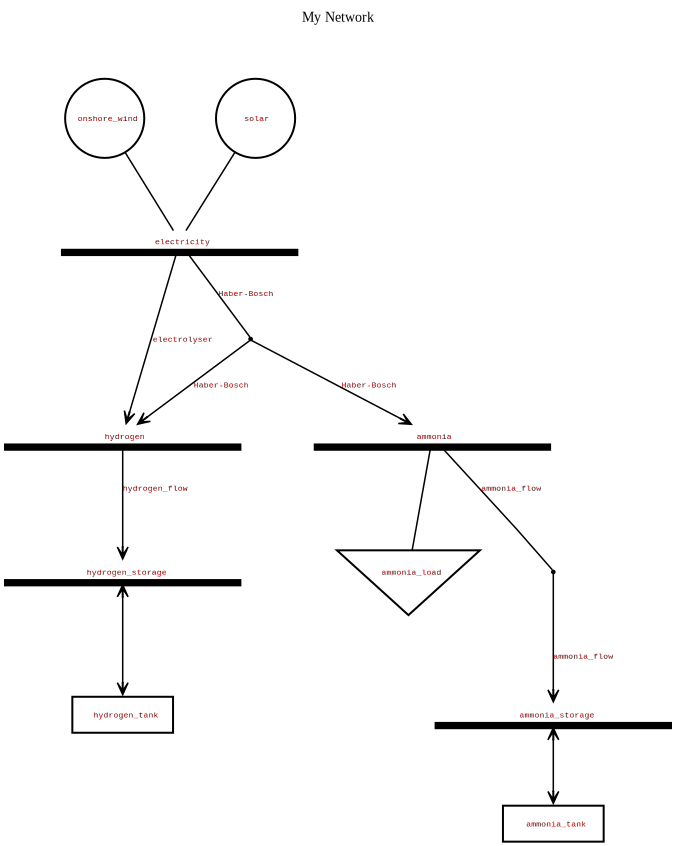

0

In [65]:
pypsatopo.generate(network)

In [66]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'electrolyser'], dtype='object', name='Link')
Index(['hydrogen_flow', 'electrolyser'], dtype='object', name='Link')


INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 37.05it/s]
INFO:linopy.io: Writing time: 1.23s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-eq1qp_r2.lp -pyomo False -solve -solu /tmp/linopy-solve-9_lb1o83.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 69350 (-132138) rows, 43076 (-44532) columns and 177755 (-211708) elements
Perturbing problem by 0.001% of 1466.8756 - largest nonzero change 0.0009999981 ( 6.8171979%) - largest zero change 0.00099996377
0  Obj 11948736 Primal inf 800545.1 (8760)
571  Obj 11958279 Primal inf 968015.23 (8873)
1142  Obj 11971393 Primal inf 1129268.2 (8512)
1713  O

('ok', 'optimal')

<Axes: xlabel='snapshot'>

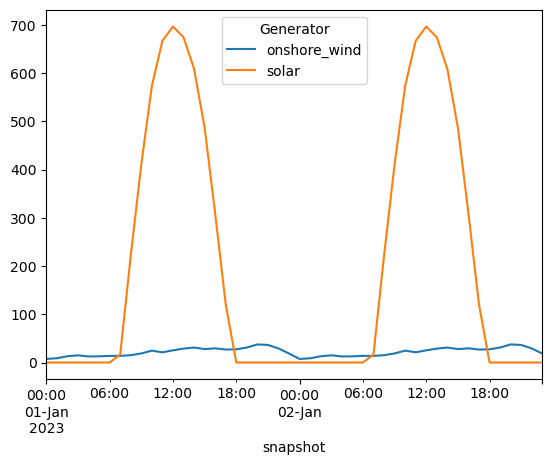

In [67]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

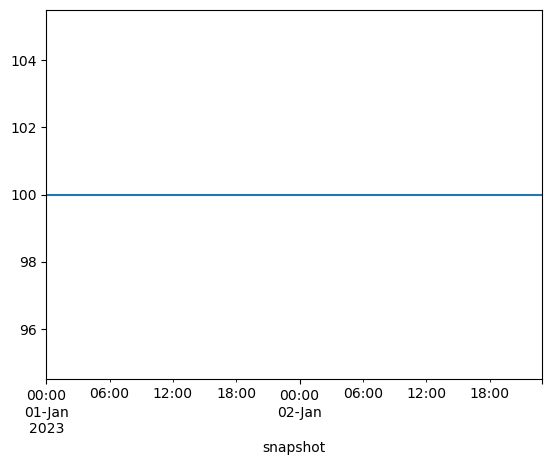

In [68]:
network.loads_t.p["ammonia_load"][:24*2].plot()

<Axes: xlabel='snapshot'>

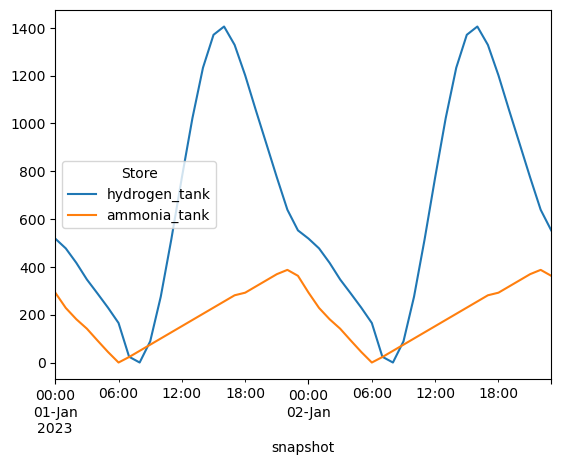

In [69]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
network.stores_t.e[:24*2].plot()